## Test Case 1

First, deploy a 1-GPU vLLM instance for Llama 1B configured to use 60% of VRAM, and this instance runs on GPU 0.

Next, deploy a 4-GPU vLLM instance for Qwen 235B configured to use 90% of VRAM, allowing us to clearly identify which GPUs are assigned to each model.

We can observe that the Qwen vLLM instance is scheduled on GPUs 4-7, demonstrating that the K8s-device-plugin is topology-aware and allocates GPUs intelligently.

![Benchmark Result](images/image1.png)

## Test Case 2

First, deploy 8 x 1-GPU vLLM instance for Llama 1B to utilize all 8 GPUs, and then delete the vLLM instances on GPU 0/2/4/6:

![Benchmark Result](images/image2.png)

Next, deploy a 4-GPU vLLM instance for Qwen 235B. We can observe that the Qwen vLLM instance can still be scheduled by the K8S-device-plugin and run on GPU 0/2/4/6, as expected.

![Benchmark Result](images/image3.png)

**This can occur in real-world scenarios: initially, all 4-GPU vLLM instances may occupy GPUs 0–3 or 4–7. Over time, 1-GPU Pods may be rescheduled due to autoscaling, resulting in non-consecutive available GPUs on some nodes. Consequently, newly-created 4-GPU vLLM instances may end up using GPUs across both NUMA nodes.**

## Performance Comparison

We already have benchmark data for vLLM 0.15.1 with Qwen running on GPUs 0–3 (or 4-7). Now, we just need to run the same test on GPUs 0/2/4/6 and then compare the results.

Model: [Qwen/Qwen3-235B-A22B-Instruct-2507-FP8](https://huggingface.co/Qwen/Qwen3-235B-A22B-Instruct-2507-FP8)

vLLM: [docker.io/vllm/vllm-openai-rocm:v0.15.1](https://hub.docker.com/layers/vllm/vllm-openai-rocm/v0.15.1/images/sha256-4c7fbd92fe07e4dab956d283b5d61b971f6242516647df6af06fdcbc34fddc2c)

Totally 40 test cases, using num_prompts values from 1 to 40, and both input and output lengths are set to 1024.

The results indicate that using 4 GPUs across both NUMA nodes significantly degrades performance. LLM Inference workloads involve both CPU and GPU operations, and each token generation requires CPU processing (like Top-K sampling). When GPUs span multiple NUMA nodes, CPU–GPU communication must cross nodes, introducing additional latency and reducing overall throughput.

In [12]:
import json
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy
%matplotlib inline  

In [26]:
# Collected Data
df = pd.read_csv("./Qwen3-235B-A22B-Instruct-2507-FP8_vllm_20260218.csv")

In [27]:
df['base_url'].unique()

array(['http://mi325-vllm-0111.default.svc.cluster.local:80',
       'http://mi325-vllm-0151.default.svc.cluster.local:80'],
      dtype=object)

In [28]:
df['others'].unique()

array(['doks-1.34.1-rocm-7.0.2-mi325x8-vllm',
       'doks-1.34.1-rocm-7.0.2-mi325x8-vllm-gpu0246'], dtype=object)

In [29]:
# All requests are successfully processed
df [ df['failed'] >0 ] 

,max_concurrent_requests,mean_tpot_ms,endpoint_type,p99_itl_ms,max_concurrency,mean_itl_ms,request_throughput,others,task_id,max_output_tokens_per_s,...,output_throughput,date,std_itl_ms,p99_ttft_ms,std_ttft_ms,total_token_throughput,burstiness,base_url,std_tpot_ms,num_prompts


In [37]:
# Samples: vLLM 0.15.1 on GPU 0-3 
df_0151_0123 = df[ (df["base_url"] == "http://mi325-vllm-0151.default.svc.cluster.local:80") & (df["others"] == "doks-1.34.1-rocm-7.0.2-mi325x8-vllm")          ].copy()
# Samples: vLLM 0.15.1 on GPU 0/2/4/6
df_0151_0246 = df[ (df["base_url"] == "http://mi325-vllm-0151.default.svc.cluster.local:80") & (df["others"] == "doks-1.34.1-rocm-7.0.2-mi325x8-vllm-gpu0246")  ].copy()

df_0151_0123 = df_0151_0123.sort_values("num_prompts")
df_0151_0246 = df_0151_0246.sort_values("num_prompts")

print(df_0151_0123.shape)
print(df_0151_0246.shape)

(40, 37)
(40, 37)


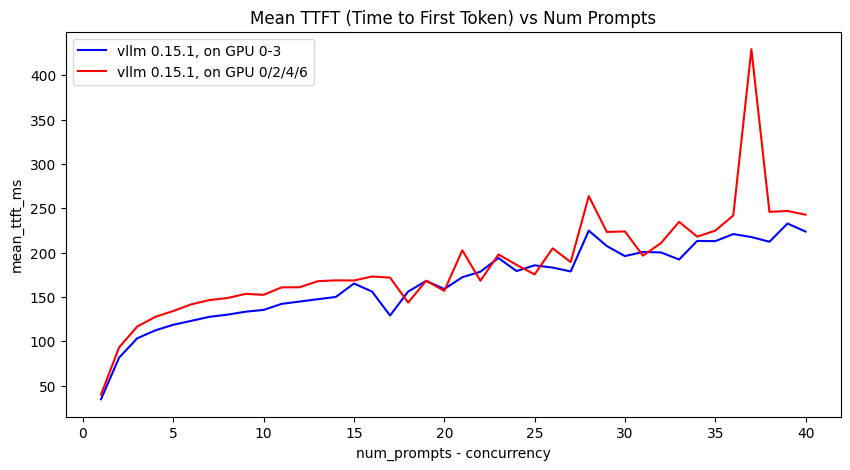

In [38]:
plt.figure(figsize=(10, 5)) 

plt.plot(
    df_0151_0123["num_prompts"],
    df_0151_0123["mean_ttft_ms"],
    color="blue",
    label="vllm 0.15.1, on GPU 0-3"
)

plt.plot(
    df_0151_0246["num_prompts"],
    df_0151_0246["mean_ttft_ms"],
    color="red",
    label="vllm 0.15.1, on GPU 0/2/4/6"
)

plt.xlabel("num_prompts - concurrency")
plt.ylabel("mean_ttft_ms")
plt.title("Mean TTFT (Time to First Token) vs Num Prompts")
plt.legend()

plt.show()

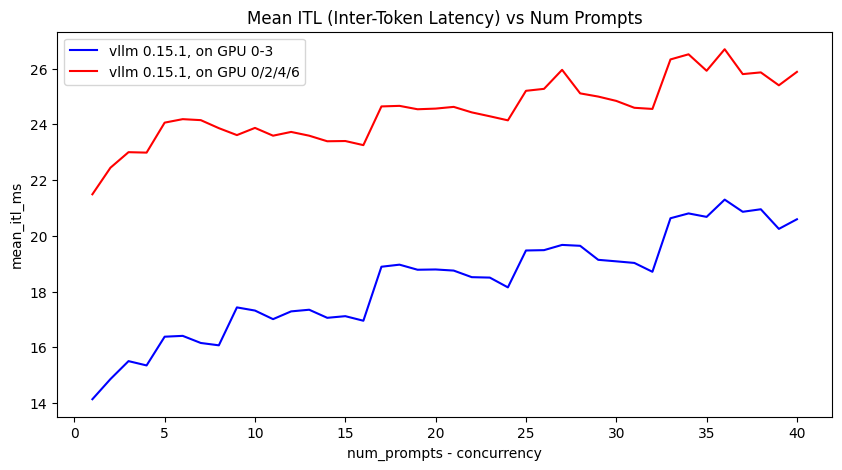

In [34]:
plt.figure(figsize=(10, 5)) 

plt.plot(
    df_0151_0123["num_prompts"],
    df_0151_0123["mean_itl_ms"],
    color="blue",
    label="vllm 0.15.1, on GPU 0-3"
)

plt.plot(
    df_0151_0246["num_prompts"],
    df_0151_0246["mean_itl_ms"],
    color="red",
    label="vllm 0.15.1, on GPU 0/2/4/6"
)

plt.xlabel("num_prompts - concurrency")
plt.ylabel("mean_itl_ms")
plt.title("Mean ITL (Inter-Token Latency) vs Num Prompts")
plt.legend()

plt.show()

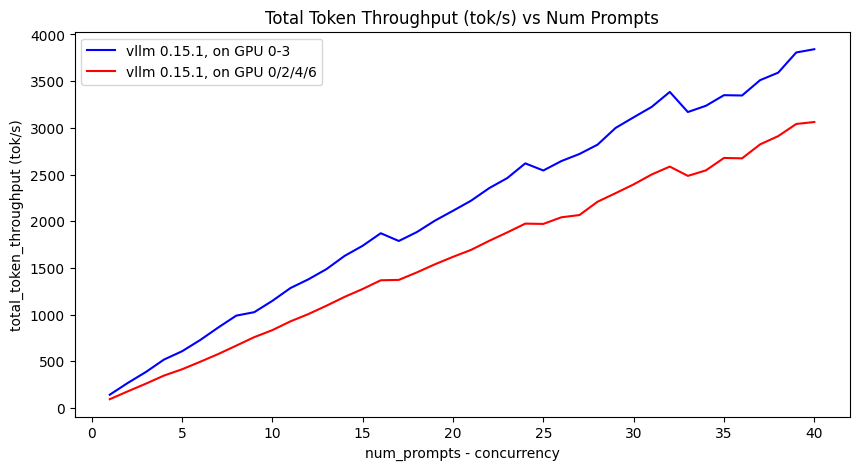

In [35]:
plt.figure(figsize=(10, 5)) 

plt.plot(
    df_0151_0123["num_prompts"],
    df_0151_0123["total_token_throughput"],
    color="blue",
    label="vllm 0.15.1, on GPU 0-3"
)

plt.plot(
    df_0151_0246["num_prompts"],
    df_0151_0246["total_token_throughput"],
    color="red",
    label="vllm 0.15.1, on GPU 0/2/4/6"
)

plt.xlabel("num_prompts - concurrency")
plt.ylabel("total_token_throughput (tok/s)")
plt.title("Total Token Throughput (tok/s) vs Num Prompts")
plt.legend()

plt.show()

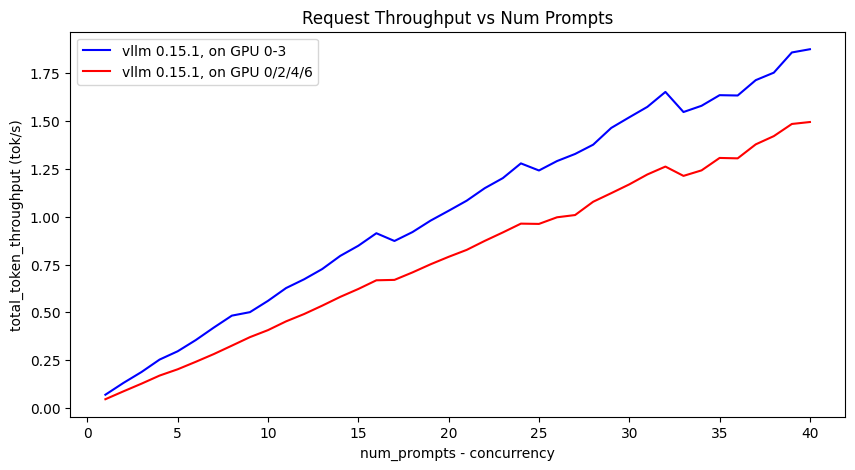

In [36]:
plt.figure(figsize=(10, 5)) 

plt.plot(
    df_0151_0123["num_prompts"],
    df_0151_0123["request_throughput"],
    color="blue",
    label="vllm 0.15.1, on GPU 0-3"
)

plt.plot(
    df_0151_0246["num_prompts"],
    df_0151_0246["request_throughput"],
    color="red",
    label="vllm 0.15.1, on GPU 0/2/4/6"
)

plt.xlabel("num_prompts - concurrency")
plt.ylabel("total_token_throughput (tok/s)")
plt.title("Request Throughput vs Num Prompts")
plt.legend()

plt.show()